In [1]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import json
import os
import math
import librosa


ModuleNotFoundError: No module named 'librosa'

In [62]:
DATASET_PATH = "/content/drive/MyDrive/Kaggle/data"
JSON_PATH = "/content/drive/MyDrive/Kaggle/data/data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 3 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [66]:



def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=1):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{},labels:{}, segment:{}".format(file_path,i-1, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        


In [67]:
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH)


Processing: Parsed_Capuchinbird_Clips
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114131-1.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114131-2.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114131-3.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114132-0.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114131-4.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114132-2.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114132-1.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114132-4.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114132-3.wav,labels:0, segment:1
/content/drive/MyDrive/Kaggle/data/Parsed_Capuchinbird_Clips/XC114132-5.wav,labels:0, segment:1
/

In [68]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [69]:
DATA_PATH = "/content/drive/MyDrive/Kaggle/data/data_10.json"

In [70]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


In [71]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [72]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [73]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model

In [74]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

In [75]:
X_train


array([[[[-6.18787476e+02],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[-6.09904358e+02],
         [ 9.45842361e+00],
         [ 2.49954319e+00],
         ...,
         [-5.29575157e+00],
         [-4.73227215e+00],
         [-3.01372647e+00]],

        [[-5.43126953e+02],
         [ 4.77441483e+01],
         [-1.93472214e+01],
         ...,
         [-9.15106010e+00],
         [-7.48139954e+00],
         [-2.69625473e+00]],

        ...,

        [[-2.44826630e+02],
         [ 9.70381165e+01],
         [-8.44044724e+01],
         ...,
         [-2.92677612e+01],
         [-2.24480610e+01],
         [-1.42635765e+01]],

        [[-2.41866653e+02],
         [ 1.09980469e+02],
         [-7.62680054e+01],
         ...,
         [-2.25490532e+01],
         [-2.00867558e+01],
         [-9.53737259e+00]],

        [[-2.44535339e+02],
         [ 1.19298325e+02],
         [

In [76]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

In [86]:
input_shape

(130, 13, 1)

In [77]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [78]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
11/11 [==============================] - 14s 67ms/step - loss: 0.8947 - accuracy: 0.6199 - val_loss: 1.0190 - val_accuracy: 0.6667
Epoch 2/30
11/11 [==============================] - 0s 12ms/step - loss: 0.4940 - accuracy: 0.7695 - val_loss: 0.8789 - val_accuracy: 0.6667
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 0.3663 - accuracy: 0.8536 - val_loss: 0.7487 - val_accuracy: 0.6667
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 0.2649 - accuracy: 0.8847 - val_loss: 0.6248 - val_accuracy: 0.6790
Epoch 5/30
11/11 [==============================] - 0s 14ms/step - loss: 0.2291 - accuracy: 0.9128 - val_loss: 0.5425 - val_accuracy: 0.7037
Epoch 6/30
11/11 [==============================] - 0s 12ms/step - loss: 0.2055 - accuracy: 0.9221 - val_loss: 0.4736 - val_accuracy: 0.7654
Epoch 7/30
11/11 [==============================] - 0s 12ms/step - loss: 0.1756 - accuracy: 0.9533 - val_loss: 0.4194 - val_accuracy: 0.7901
Epoch 8/30
1

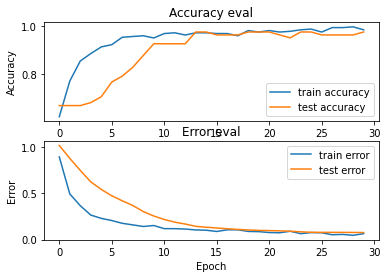

In [79]:
plot_history(history)

In [80]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

5/5 - 0s - loss: 0.0654 - accuracy: 0.9778 - 112ms/epoch - 22ms/step

Test accuracy: 0.9777777791023254


In [81]:
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [83]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [84]:
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 124ms/step
Target: 1, Predicted label: [1]


In [91]:
X_test.shape

(135, 130, 13, 1)

In [89]:
y_actual=y_test
y_pred=[]

In [94]:
for i in X_test:
  X = i
  X = X[np.newaxis, ...]
  prediction = model.predict(X)
  predicted_index = np.argmax(prediction, axis=1)
  y_pred=np.append(y_pred,predicted_index)

1/1 [==============================] - 0s 24ms/step


In [95]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [96]:
cm=confusion_matrix(y_true=y_actual,y_pred=y_pred)

In [97]:
def plot_confusion_matrix(cm,classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix,without Normalization')
    print(cm)


    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
      


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix,without Normalization
[[43  2]
 [ 1 89]]


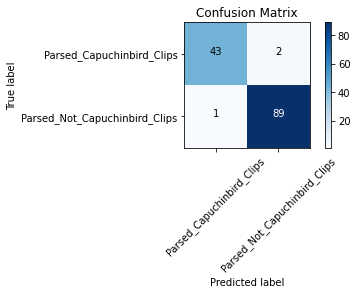

In [99]:
cm_plot_labels=['Parsed_Capuchinbird_Clips','Parsed_Not_Capuchinbird_Clips']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')